<a href="https://colab.research.google.com/github/diaa-shalaby/NLP-Sentiment-analysis-thedeep/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
# files.upload()

In [2]:
!git clone https://github.com/diaa-shalaby/NLP-Sentiment-analysis-thedeep.git

Cloning into 'NLP-Sentiment-analysis-thedeep'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 7), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [ ]:
# %cp NLP.ipynb /content/NLP-Sentiment-analysis-thedeep

In [3]:
import numpy as np
from numba import njit
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import timeit
import re

import pandas as pd
import numpy as np
import itertools
import spacy
import gensim
import sklearn

from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models import LogEntropyModel
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import gensim.downloader as api
from gensim.models import Word2Vec

from scipy import stats
import random

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm_notebook

from argparse import Namespace
import dill
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
# from transformers import BertTokenizer, BertModel, BertConfig

Exploring dataset

In [4]:
# !python -m spacy download en_core_web_md

In [6]:
DATASET_SIZE = 'medium' # or medium

# Unprocessed
# TRAIN_DATA_PATH = f"/content/NLP-Sentiment-analysis-thedeep/thedeep.{DATASET_SIZE}.train.txt"
# VALID_DATA_PATH = f"/content/NLP-Sentiment-analysis-thedeep/thedeep.{DATASET_SIZE}.validation.txt"
# TEST_DATA_PATH = f"/content/NLP-Sentiment-analysis-thedeep/thedeep.{DATASET_SIZE}.test.txt"

# Processed
TRAIN_DATA_PATH = f"/content/NLP-Sentiment-analysis-thedeep/df_train.csv"
VALID_DATA_PATH = f"/content/NLP-Sentiment-analysis-thedeep/df_valid.csv"
TEST_DATA_PATH = f"/content/NLP-Sentiment-analysis-thedeep/df_test.csv"
LABEL_CAPTIONS_PATH = "/content/NLP-Sentiment-analysis-thedeep/thedeep.labels.txt"


#Set Hyperparameter for Bag of Words 
MAX_NB_WORDS = 20_000

nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_md")

In [10]:
def load_dataset(data_path):
    # df_data = pd.read_csv(data_path, sep=',', header = None, names=['sentence_id', 'text', 'label']) # Unprocessed
    df_data = pd.read_csv(data_path, index_col=0)
    return df_data

In [11]:
# Load the data into train, validation and test set
df_train = load_dataset(TRAIN_DATA_PATH)
df_test = load_dataset(TEST_DATA_PATH)
df_valid = load_dataset(VALID_DATA_PATH)

# Sample 10% for faster training on limited resources
# df_train = df_train.sample(frac=0.1)
# df_test = df_test.sample(frac=0.1)
# df_valid = df_valid.sample(frac=0.1)

In [12]:
# Print out shapes of the sets
print(f'Train set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')
print(f'Validation set shape: {df_valid.shape}')

df_train.head()

Train set shape: (26600, 4)
Test set shape: (5700, 4)
Validation set shape: (5700, 4)


,sentence_id,text,label,text_preprocessed
0,11609,"• 214,000 students affected as schools close d...",9,"['student', 'affect', 'as', 'school', 'close',..."
1,28291,The primary reported needs for IDPs across the...,4,"['the', 'primary', 'report', 'need', 'for', 'i..."
2,9695,Some 602 000 IDPs are now spread across the co...,3,"['some', 'idp', 'be', 'now', 'spread', 'across..."
3,7781,South Sudanese soldiers accused of raping at l...,9,"['south', 'sudanese', 'soldier', 'accuse', 'of..."
4,31382,"Since the beginning of 2017, 18 882 suspected/...",11,"['since', 'the', 'beginning', 'of', 'suspect',..."


In [13]:
#Create the datasets with the labels

labels_train = np.array(list(df_train['label'].values))
labels_val = np.array(list(df_valid['label'].values))
labels_test = np.array(list(df_test['label'].values))

#Check the size of the datasets
print("The label-dataset for training has", len(labels_train),"rows")
print("The label-dataset for validation has", len(labels_val),"rows")
print("The label-dataset for testing has", len(labels_test),"rows")

The label-dataset for training has 26600 rows
The label-dataset for validation has 5700 rows
The label-dataset for testing has 5700 rows


In [14]:
#Create a dictionary containing the labels and their captions
def load_captions(path):
    labelcaptions = {}
    with open(path) as fr:
        for l in fr:
            vals = l.strip().split(',')
            labelcaptions[vals[1]] = int(vals[0])
            print(vals)
    return labelcaptions

print("Labels:")
labelcaptions = load_captions(LABEL_CAPTIONS_PATH)

Labels:
['0', 'Agriculture']
['1', 'Cross']
['2', 'Education']
['3', 'Food']
['4', 'Health']
['5', 'Livelihood']
['6', 'Logistic']
['7', 'NFI']
['8', 'Nutrition']
['9', 'Protection']
['10', 'Shelter']
['11', 'WASH']


### Pre-processing & Feature Extraction


Cleaning and preprocessing: the dataset contains punctuations, numbers, dates, case-sensitivity are some examples of the elements which can be potentially considered for cleaning/preprocessing. 

In [ ]:
def preprocess(docs):
    tokens = nlp(docs)

    lemma_list = []
    for w_token in tokens:
        lemma = re.sub('<[^>]*>', '', w_token.lemma_)
        lemma = re.sub('[\W]+', '', lemma.lower())
        lemma = re.sub("\d*|^\d*\s|\s\d*\s|\s\d*$", '', lemma)

        if lemma != '':
            lemma_list.append(lemma.lower())

    return lemma_list

df_train['text_preprocessed'] = [preprocess(data[1]) for data in np.array(df_train)]
df_test['text_preprocessed'] = [preprocess(data[1]) for data in np.array(df_test)]
df_valid['text_preprocessed'] = [preprocess(data[1]) for data in np.array(df_valid)]

In [16]:
df_train[['text', 'text_preprocessed']].head()

,text,text_preprocessed
0,"• 214,000 students affected as schools close d...","['student', 'affect', 'as', 'school', 'close',..."
1,The primary reported needs for IDPs across the...,"['the', 'primary', 'report', 'need', 'for', 'i..."
2,Some 602 000 IDPs are now spread across the co...,"['some', 'idp', 'be', 'now', 'spread', 'across..."
3,South Sudanese soldiers accused of raping at l...,"['south', 'sudanese', 'soldier', 'accuse', 'of..."
4,"Since the beginning of 2017, 18 882 suspected/...","['since', 'the', 'beginning', 'of', 'suspect',..."


In [17]:
print(f'Original sentence: {np.array(df_train)[42][1]}\n')

print(f'After preprocessing: {np.array(df_train.text_preprocessed)[42]}')

Original sentence: The Libyan Coastguard found 80 survivors clinging to their almost airless raft with seven bodies floating nearby. AFP also reported that the Tunisian coastguard had picked up a boat whose 126 passengers had been drifting without an engine for two days. On board was the body of a woman.  

After preprocessing: ['the', 'libyan', 'coastguard', 'find', 'survivor', 'cling', 'to', 'pron', 'almost', 'airless', 'raft', 'with', 'seven', 'body', 'float', 'nearby', 'afp', 'also', 'report', 'that', 'the', 'tunisian', 'coastguard', 'have', 'pick', 'up', 'a', 'boat', 'whose', 'passenger', 'have', 'be', 'drift', 'without', 'an', 'engine', 'for', 'two', 'day', 'on', 'board', 'be', 'the', 'body', 'of', 'a', 'woman']


In [15]:
# From now on we'll only use the preprocessed text
docs_train = df_train.text_preprocessed.to_numpy()
docs_test = df_test.text_preprocessed.to_numpy()
docs_valid = df_valid.text_preprocessed.to_numpy()

labels_train = df_train.label.to_numpy()
labels_test = df_test.label.to_numpy()
labels_valid = df_valid.label.to_numpy()

tokens_count = {}
for doc in docs_train:
    for token in doc:
        if (token in tokens_count):
            tokens_count[token] += 1
        else:
            tokens_count[token] = 1

tokens_count = {k: v for k, v in sorted(tokens_count.items(), key=lambda item: item[1], reverse=True)}

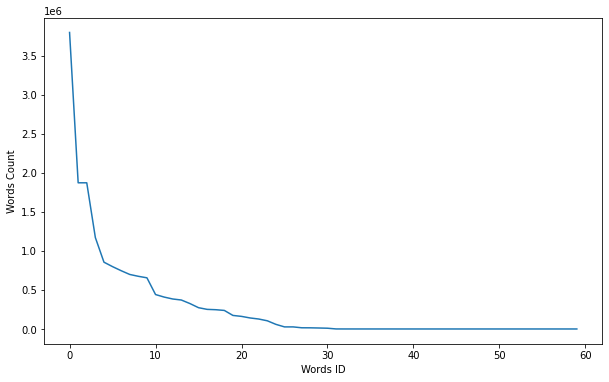

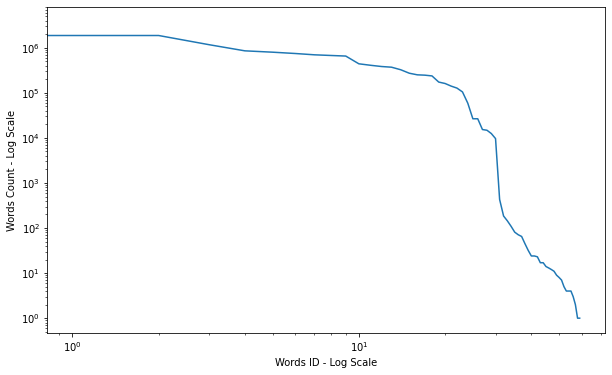

Different Words with (spacy) Stopwords: 60
Top 10 Words with (spacy) Stopwords: ["'", ',', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r']
Top 10 occurrences with (spacy) Stopwords: [3797394, 1872097, 1872097, 1170414, 855367, 798330, 746331, 698187, 674587, 655160]


In [18]:
# PLOT
#
# WordsCount vs Number of words
#
# and print the Top-5-stopwords and how often they occur

plt.figure(figsize=(10,6))
plt.plot(list(tokens_count.values()))
#plt.axhline(y = 1500, color = 'r', linestyle = '-')

plt.xlabel('Words ID')
plt.ylabel('Words Count')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(list(tokens_count.values()))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Words ID - Log Scale')
plt.ylabel('Words Count - Log Scale')
plt.show()

print("Different Words with (spacy) Stopwords:", len(tokens_count))
print("Top 10 Words with (spacy) Stopwords:", list(tokens_count.keys())[0:10])
print("Top 10 occurrences with (spacy) Stopwords:", list(tokens_count.values())[0:10])

**Create a dictionary of vocabulary:** Next, reduce the size of dictionary by considering a cut-off threshold on the tokens with low frequencies. When removing tokens from the dictionary, consider a strategy for handling Out-Of-Vocabulary (OOV) tokens, namely the ones in the train/validation/test datasets that that are not anymore in the dictionary. Some possible strategies could be to remove OOVs completely from the texts, or to replace them with a special token like <OOV\>. Explain your approaches and report the statistics of the dictionary before and after the reduction.

Exclude extremely frequent as well as extremely unfrequent *words* in the dictionary *italicized text*

In [39]:
import ast
# json.loads(docs_train[0])
s = docs_train[0]

destring_lists = lambda s: ast.literal_eval(_) for _ in s 
np.apply_along_axis(destring_lists, 0, docs_train)

SyntaxError: ignored

In [19]:
dic = Dictionary(docs_train)
dic.filter_extremes(no_below=1, no_above=0.5, keep_n=20000)
dic.compactify()
print("Total %s unique tokens." % len(dic), '\n')

print('First 5 words: \n')
for _ in range(5):
  print(dic[_])

TypeError: ignored

In [ ]:
docs_train[0][:10]

['student',
 'affect',
 'as',
 'school',
 'close',
 'due',
 'to',
 'insecurity',
 'people',
 'kill']

In [ ]:
dic.doc2bow(docs_train[0][:10])

[(0, 1), (2, 1), (4, 1), (5, 1), (10, 1), (11, 1), (14, 1), (15, 1), (16, 1)]

In [ ]:
docs_train_bow = [dic.doc2bow(_doc) for _doc in docs_train] 
docs_val_bow = [dic.doc2bow(_doc) for _doc in docs_valid] 
docs_test_bow = [dic.doc2bow(_doc) for _doc in docs_test] 

## Creating sentence vectors

Using weight-model: tf-idf using ***gensim*** models

In [ ]:
weight_model = TfidfModel(docs_train_bow)

docs_train_tfidf=[]
for _bow in docs_train_bow:
    docs_train_tfidf.append(weight_model[_bow])
    
docs_val_tfidf=[]
for _bow in docs_val_bow:
    docs_val_tfidf.append(weight_model[_bow])

docs_test_tfidf=[]
for _bow in docs_test_bow:
    docs_test_tfidf.append(weight_model[_bow])
    

In [ ]:
docs_train_tfidf[42][:10]

[(19, 0.040077672242059825),
 (32, 0.028428073967148196),
 (53, 0.040094582652668104),
 (58, 0.0333450692310753),
 (64, 0.054132310021852856),
 (124, 0.031923243150406545),
 (137, 0.025090766040193085),
 (162, 0.03185719776283453),
 (231, 0.10643646806170173),
 (425, 0.07423126800353015)]

In [ ]:
docs_train_tfidf_sparse = np.zeros((len(docs_train_tfidf), len(dic)))
for doc_i, doc in enumerate(docs_train_tfidf):
    for item in doc:
        docs_train_tfidf_sparse[doc_i][item[0]] = item[1]
        
docs_val_tfidf_sparse = np.zeros((len(docs_val_tfidf), len(dic)))
for doc_i, doc in enumerate(docs_val_tfidf):
    for item in doc:
        docs_val_tfidf_sparse[doc_i][item[0]] = item[1]
        
docs_test_tfidf_sparse = np.zeros((len(docs_test_tfidf), len(dic)))
for doc_i, doc in enumerate(docs_test_tfidf):
    for item in doc:
        docs_test_tfidf_sparse[doc_i][item[0]] = item[1]


In [ ]:
docs_train_tfidf_sparse.shape

(26600, 20000)

In [ ]:
# Calculate and report the sparsity rate of the vectors of train, 
# validation, and test sets, namely what percentages of the vectors in each set are filled with zeros.

from numpy import count_nonzero

print("The sparsity rate of the tf-idf-variation is:\n")
sparsity = 1.0 - ( count_nonzero(docs_train_tfidf_sparse) / float(docs_train_tfidf_sparse.size) )
percentage = "{:.5%}".format(sparsity)
print("for the Training-Set:  ",percentage)
sparsity = 1.0 - ( count_nonzero(docs_val_tfidf_sparse) / float(docs_val_tfidf_sparse.size) )
percentage = "{:.5%}".format(sparsity)
print(f"for the Validation-Set:",percentage)
sparsity = 1.0 - ( count_nonzero(docs_test_tfidf_sparse) / float(docs_test_tfidf_sparse.size) )
percentage = "{:.5%}".format(sparsity)
print("for the Test-Set:      ",percentage)

The sparsity rate of the tf-idf-variation is:

for the Training-Set:   99.78761%
for the Validation-Set: 99.78930%
for the Test-Set:       99.79209%


#### Apply SVD for dimensionality reduction to 300 dimensions

In [ ]:
svd = sklearn.decomposition.TruncatedSVD(n_components=300)
svd.fit(docs_train_tfidf_sparse)

vecs_train = svd.transform(docs_train_tfidf_sparse)
vecs_val = svd.transform(docs_val_tfidf_sparse)
vecs_test = svd.transform(docs_test_tfidf_sparse)

print("These are the dimensions after the SVD of the tf-idf variant:")
print ("Training Set:   ", vecs_train.shape)
print ("Validation Set: ", vecs_val.shape)
print ("Test Set:       ", vecs_test.shape)

These are the dimensions after the SVD of the tf-idf variant:
Training Set:    (26600, 300)
Validation Set:  (5700, 300)
Test Set:        (5700, 300)


#### Apply TSNE for further dimensionality reduction to 2 dimensions for plotting.

In [ ]:
tsne = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random')
vecs_train_2dim = tsne.fit_transform(vecs_train)
print(f'After tsne the shape is: {vecs_train_2dim.shape}')

After tsne the shape is: (26600, 2)


In [ ]:
labels_train

array([ 9,  4,  3, ..., 10,  9,  4])

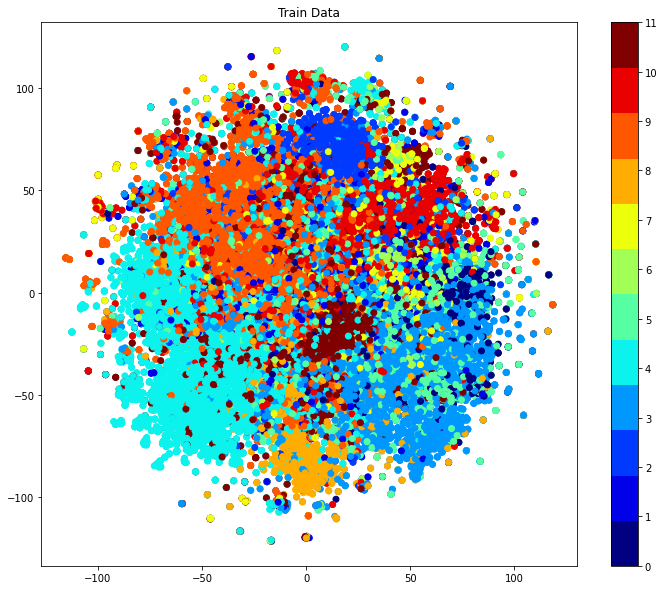

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(vecs_train_2dim[:, 0], vecs_train_2dim[:, 1], c=labels_train, cmap=plt.cm.get_cmap("jet", np.max(labels_train)+1))
plt.colorbar(ticks=range(14))
plt.title("Train Data")
# plt.clim(-0.5, 9.5)
plt.show()

# Training and Sentiment analysis

Select two classification algorithms from standard machine learning classifiers. Using each classification algorithm, train a machine learning model on each of the variations of feature vectors. This should result in eight experiment sets (4 variations of feature vectors × 2 classification algorithms). The ML model in each of the experiments possibly have several involving hyper-parameters (also keep in mind the dimensionality size 𝑘 in the low-dimensional vectors as yet another hyper-parameter). For each experiment, select one of the hyper-parameters and tune its value. The tuning process is done by first assigning at least five different values to the hyper-parameter, then training separate models based on each value, and finally using the evaluation results on the validation set to select the best-performing model. Report the studied hyper-parameters, the evaluation results of each on validation set, and finally the selected value of the hyper-parameter. 

In [20]:
# Dummy baseline classifier
def dummy_classifier(train_set, labels, test_set):
    clf = DummyClassifier(strategy='stratified')
    clf.fit(train_set, labels)
    dummy_preds = clf.predict(test_set)
    return dummy_preds

In [21]:
# Hyperparameters for logistic regression
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid_log = dict(solver=solvers, penalty=penalty, C=c_values)

# Hyperparameters for support vector machine
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
grid_svm = dict(kernel=kernel,C=C,gamma=gamma)

In [ ]:
def training():  
    """
    Creates 8 models (2 algorithms x 4 variations of feature vectors).
    
    returns: 2 dictionaries; each containing 4 models for the 4 variations
    """
    logistic_models = {}
    svm_models = {}

    for train_set, str_train_set in [[docs_train_tfidf_sparse, 'docs_train_tfidf_sparse'], 
                                     [vecs_train, 'vecs_train'], 
                                     [docs_train_Log_sparse, 'docs_train_Log_sparse'], 
                                     [vecs_log_train, 'vecs_log_train']]:
        
        logistic_models[str_train_set] = LogisticRegression()
        svm_models[str_train_set] = SVC()
    
    return logistic_models, svm_models
    
# Now we have 2 dictionaries with 4 models each.

logistic_models, svm_models = training()

In [ ]:
# models_log_reg = {'docs_train_tfidf_sparse':[],'vecs_train':[], 'docs_train_Log_sparse':[], 'vecs_log_train':[]} 
# models_svm = {'docs_train_tfidf_sparse':[],'vecs_train':[], 'docs_train_Log_sparse':[], 'vecs_log_train':[]} 
models_log_reg = {}
models_svm = {}

def tunning(model, grid, dict_models, max_train= 20):
    for train_set, str_train_set in [[docs_train_tfidf_sparse, 'docs_train_tfidf_sparse'], 
                                     [vecs_train, 'vecs_train'], 
                                     [docs_train_Log_sparse, 'docs_train_Log_sparse'], 
                                     [vecs_log_train, 'vecs_log_train']]:
        
        best_models = {'best_score':[], 'best_estimator':[]}
        
        # define grid search
#         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        grid_search = RandomizedSearchCV(n_iter=5, estimator=model, param_distributions=grid, n_jobs=-1, cv=None, scoring='accuracy')
        grid_result = grid_search.fit(train_set[:max_train], labels_train[:max_train])
        
        best_models['best_score'].append(grid_result.best_score_)
        best_models['best_estimator'].append(grid_result.best_estimator_)

        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
            
        print(str_train_set)
            
        dict_models[str_train_set] = (grid_result.best_estimator_)
            
    return dict_models
            
best_log_models = tunning(LogisticRegression(), grid_log, models_log_reg)
best_svm_models = tunning(SVC(), grid_svm, models_svm)

In [ ]:
print(best_svm_models)

Evaluate the selected model of the eight experiment on the test set and report the results of the experiments on both validation and test sets (side by side) in one table as well as in one plot. Compare different models. Are the test results lower(/higher) than the validation results? If it is the case, where can it be rooted from? Among all these models and variations, what are the most important factors improving the classification results?

In [ ]:
predictions_log = {}
variants = ['docs_train_tfidf_sparse', 'vecs_train', 'docs_train_Log_sparse', 'vecs_log_train']
test_sets = [docs_test_tfidf_sparse, vecs_test, docs_test_Log_sparse, vecs_log_test]
val_sets = [docs_val_tfidf_sparse, vecs_val, docs_val_Log_sparse, vecs_log_val]

for variant, val_set, test_set in zip(variants, val_sets, test_sets):
#     print( dict({'val_pred':best_log_models[variant].predict(val_set), 'test_pred':best_log_models[variant].predict(test_set)}) )
    predictions_log[variant] = dict({'val_pred':best_log_models[variant].predict(val_set), 
                                     'test_pred':best_log_models[variant].predict(test_set)}


In [ ]:
predictions_log

In [ ]:
results={}

for modelname in predictions_log.keys():
    print (modelname)
    results[modelname] = sklearn.metrics.classification_report(labels_test, predictions_log[modelname]['test_pred'], output_dict=True)